<a href="https://colab.research.google.com/github/fredhu0514/Ali_Ebay/blob/main/Full_Model_MCMC_Test_Impute_blind_W_Formal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
from scipy.stats import norm, invgamma, multivariate_normal
from numpy.linalg import inv as inv
import pandas as pd

N = 1000
np.random.seed(7)

mean_X = np.array([0.0, 0.0])
cov_X = np.array([[4.0, 0.0], [0.0, 6.0]])
data_X = np.array([np.random.multivariate_normal(mean_X, cov_X) for _ in range(N)])

beta0 = np.array([1.0, -2.0, 3.0])
beta1 = np.array([0.5, -0.3, 0.1])
std1 = 1.0
std0 = 2.0
rho = 0.3
def generate_Y(X1i, X2i, beta0=beta0, beta1=beta1, std1=std1, std0=std0, rho=rho):
  X_vec = np.array([1.0, X1i, X2i])
  mean_Y = np.array([np.dot(X_vec, beta1), np.dot(X_vec, beta0)])
  cov_Y = np.array([[std1 ** 2, rho * std0 * std1], [rho * std0 * std1, std0 ** 2]])
  return np.random.multivariate_normal(mean_Y, cov_Y)
data_Y01 = np.array([generate_Y(X[0], X[1]) for X in data_X])

beta_W = np.array([0.1, -0.5, 0.5])
def eta(mean=0.0, std=1.0):
  return np.random.normal(mean, std ** 2)
data_Z = np.array([np.dot(np.array([1.0, X[0], X[1]]), beta_W) + eta() for X in data_X])

data_W = np.where(data_Z > 0.0, 1.0, 0.0)
data_Y = data_Y01[:, 0] * data_W + data_Y01[:, 1] * (1 - data_W)
data_S_blind = np.array([np.random.binomial(1, 0.5) for _ in range(N)])
data_W_S_blind = data_W.copy()
data_W_S_blind[data_S_blind == 0] = None

beta_S_info = np.array([0.3, 3.5, 4.0])
probid_link_func = lambda X: norm.cdf(np.dot(np.array([1.0, X[0], X[1]]), beta_S_info), 0.0, 1.0)
data_S_info = np.array([np.random.binomial(1, probid_link_func(X)) for X in data_X])

data_W_S_info = data_W.copy()
data_W_S_info[data_S_info == 0] = None

columns = ['Y1', 'Y0', 'Z', 'X1', 'X2', 'S_true', 'W_true', 'S_blind', 'W_blind', 'S_info', 'W_info', 'Y']
values = np.array([data_Y01[:, 0], data_Y01[:, 1], data_Z, data_X[:, 0], data_X[:, 1], np.ones(N), data_W, data_S_blind, data_W_S_blind, data_S_info, data_W_S_info, data_Y])
df = pd.DataFrame(data = np.transpose(values), columns = columns)
df.to_csv("DGP.csv")

df.head(15)

,Y1,Y0,Z,X1,X2,S_true,W_true,S_blind,W_blind,S_info,W_info,Y
0,1.634668,15.045491,3.052244,-0.931875,4.140925,1.0,1.0,0.0,NaN,1.0,1.0,1.634668
1,0.439072,-2.069133,-0.532315,0.815033,0.080393,1.0,0.0,0.0,NaN,1.0,0.0,-2.069133
2,1.108650,-5.591972,-2.385798,0.004131,-1.932459,1.0,0.0,1.0,0.0,0.0,NaN,-5.591972
3,3.600900,10.307598,2.930335,-3.509449,-0.002181,1.0,1.0,1.0,1.0,0.0,NaN,3.600900
4,-0.994725,5.897462,1.369449,1.200997,2.492743,1.0,1.0,0.0,NaN,1.0,1.0,-0.994725
5,-0.542307,-6.320003,-1.335289,-0.343097,-1.531982,1.0,0.0,0.0,NaN,0.0,NaN,-6.320003
6,-1.357732,3.124728,1.005054,-0.522713,1.237726,1.0,1.0,1.0,1.0,1.0,1.0,-1.357732
7,0.194640,4.400449,0.868597,-2.906483,-0.594611,1.0,1.0,1.0,1.0,0.0,NaN,0.194640
8,2.544234,5.507992,0.226695,0.247762,1.358439,1.0,1.0,1.0,1.0,1.0,1.0,2.544234
9,1.616258,8.519227,3.706591,-3.053049,0.672287,1.0,1.0,1.0,1.0,0.0,NaN,1.616258


In [53]:
class BetaW:
  def __init__(self, cov):
    self.cov = cov
  
  def probit(self, val):
    return multivariate_normal.cdf(val, 0.0, 1.0)

  def rvs(self, mu):
    return multivariate_normal.rvs(mu, self.cov)

  def ppf(self, cur_betaW, prev_betaW, df):
    cur_betaW = np.expand_dims(cur_betaW, 1)
    X0 = np.array(df[df['W'] == 0.0][['X1', 'X2']])
    X0 = np.concatenate((np.ones((X0.shape[0], 1)), X0), axis=1)
    X1 = np.array(df[df['W'] == 1.0][['X1', 'X2']])
    X1 = np.concatenate((np.ones((X1.shape[0], 1)), X1), axis=1)

    return np.product(
          np.vectorize(lambda x: 1 - self.probit(x))((X0 @ cur_betaW).squeeze())
        ) * np.product(
          np.vectorize(lambda x: self.probit(x))((X1 @ cur_betaW).squeeze())
        ) * multivariate_normal.pdf(cur_betaW.squeeze(), prev_betaW, self.cov)

betaW_funcs = BetaW(np.identity(3) * 10e-4)



class NIG:
  def __init__(self, a, b, cov):
    self.a = a
    self.b = b
    self.cov = cov

  def update_hyper_params(self, mu, category, df):
    X = np.array(df[df['W'] == category][['X1', 'X2']])
    N = X.shape[0]
    X = np.concatenate((np.ones((N, 1)), X), axis=1)
    Y = np.array(df[df['W'] == category][['Y']])
    cov_star = X.transpose() @ X + self.cov
    mu_star = inv(cov_star) @ (X.transpose() @ Y + self.cov @ mu)
    a_star = self.a + N / 2
    b_star = self.b + (Y.transpose() @ Y + mu.transpose() @ self.cov @ mu - mu_star.transpose() @ cov_star @ mu_star) / 2
    self.a = a_star
    self.b = b_star
    self.ov = cov_star
    return mu_star, cov_star, a_star, b_star

  def __call__(self, prev_beta0, prev_beta1, df):
    prev_beta0 = np.expand_dims(prev_beta0, 1)
    prev_beta1 = np.expand_dims(prev_beta1, 1)

    mu0_star, cov0_star, a0_star, b0_star = self.update_hyper_params(prev_beta0, category=0, df=df)
    mu1_star, cov1_star, a1_star, b1_star = self.update_hyper_params(prev_beta1, category=1, df=df)

    sig0_2 = invgamma.rvs(a=a0_star, scale=1 / b0_star)
    sig1_2 = invgamma.rvs(a=a1_star, scale=1 / b1_star)

    new_beta0 = multivariate_normal.rvs(mu0_star.squeeze(), inv(cov0_star) * sig0_2)
    new_beta1 = multivariate_normal.rvs(mu1_star.squeeze(), inv(cov1_star) * sig1_2)
    return new_beta0, sig0_2, new_beta1, sig1_2

betaT_rvs = NIG(1.2, 1.5, np.identity(3))

In [56]:
import time

np.random.seed(73)

def beta_W_cdf(val):
  return multivariate_normal.cdf(val, 0, 1)

def imputeW(betaW, beta0, beta1):
  def func(x):
    if x['S'] == 0.0:
      betaW_Xi = betaW[0] + betaW[1] * x['X1'] + betaW[2] * x['X2']
      beta0_Xi = beta0[0] + beta0[1] * x['X1'] + beta0[2] * x['X2']
      beta1_Xi = beta1[0] + beta1[1] * x['X1'] + beta1[2] * x['X2']

      w0 = (1 - norm.cdf(betaW_Xi)) * np.exp(- (x['Y'] - beta0_Xi) ** 2 / (2 * std0 * std0)) / np.sqrt(2 * std0 * std0 * np.pi)
      w1 = norm.cdf(betaW_Xi) * np.exp(- (x['Y'] - beta1_Xi) ** 2 / (2 * std1 * std1)) / np.sqrt(2 * std1 * std1 * np.pi)
      return np.random.binomial(1, w1 / (w1 + w0))
    else:
      return x['W']
  return func

class MCMC:
  def __init__(self, burnin_size, sample_size, dataframe, betaW_funcs, betaW_init, betaT_transition_sampling, beta0_init, beta1_init):
    self.start_time = time.time()

    self.burnin_size = burnin_size
    self.sample_size = sample_size
    self.dataframe = dataframe
    self.full_df = dataframe.copy()


    self.betaW_rvs = betaW_funcs.rvs
    self.betaW_ppf = betaW_funcs.ppf

    self.betaW_history = [betaW_init]
    self.betaW_posterior_history = [self.betaW_ppf(betaW_init, betaW_init, self.dataframe[self.dataframe['S'] == 1.0])]


    self.betaT_rvs = betaT_transition_sampling
    self.betaT_history = {'beta0':[beta0_init], 'beta1':[beta1_init], 'sigma0':[None], 'sigma1':[None]}


  def impute_W(self):
    self.full_df.apply(imputeW(self.betaW_history[-1], self.betaT_history['beta0'][-1], self.betaT_history['beta1'][-1]), axis=1)

  def metropolis(self, cur_sample, prev_sample):
    cur_posterior_full = self.betaW_ppf(cur_sample, prev_sample, self.full_df)

    R = min(cur_posterior_full / self.betaW_posterior_history[-1], 1)
    print('R', R)
    if np.random.random() < R:
      self.betaW_history.append(cur_sample)
      self.betaW_posterior_history.append(cur_posterior_full)
      return True # Accept
    return False # Reject

  def run(self):
    count = 0
    betaW_reject= 0
    betaW_sample_reject = 0
    while count < self.burnin_size + self.sample_size:
      print(count, '=' * 20)
      ### Impute W
      self.impute_W()

      ### Update betaW by MCMC 
      new_betaW = self.betaW_rvs(self.betaW_history[-1])
      if self.metropolis(new_betaW, self.betaW_history[-1]):
        self.betaW_history.append(new_betaW)
      else:
        self.betaW_history.append(self.betaW_history[-1])
        # rejection rate
        betaW_reject += 1
        if count > self.burnin_size:
          betaW_sample_reject += 1

      print('betaW', self.betaW_history[-1])
      print('+' * 15)
      
      ### Update betaT by Gibbs & MCMC
      beta0, sig0, beta1, sig1 = self.betaT_rvs(self.betaT_history['beta0'][-1], 
                                                self.betaT_history['beta1'][-1], 
                                                self.full_df)
      self.betaT_history['beta0'].append(beta0)
      self.betaT_history['beta1'].append(beta1)
      self.betaT_history['sigma0'].append(sig0)
      self.betaT_history['sigma1'].append(sig1)

      print('beta0', beta0)
      print('sigma0', sig0)
      print('beta1', beta1)
      print('sigma1', sig1)
      print("\n")

      count += 1
    print(f"Finished in {time.time() - self.start_time}")
    print("\n")
    print(f"betaW rejection rate total: {betaW_reject / count}")
    print("\n")
    print(f"betaW rejection rate sample only: {betaW_sample_reject / self.sample_size}")

In [57]:
mcmc = MCMC(burnin_size=500, 
            sample_size=4000, 
            dataframe=df[['X1', 'X2', 'Y', 'W_blind', 'S_blind']].rename(columns={'W_blind':'W', 'S_blind': 'S'}), 
            betaW_funcs=betaW_funcs, 
            betaW_init=np.zeros(3), 
            betaT_transition_sampling=betaT_rvs, 
            beta0_init=np.zeros(3), 
            beta1_init=np.zeros(3))
mcmc.run()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2246: RuntimeWarning: divide by zero encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


Streaming output truncated to the last 5000 lines.
sigma1 4.613006746434969e-13


4001 ====================
R 0.052173653728712285
betaW [ 0.03387296 -0.57365003  0.60000839]
+++++++++++++++
beta0 [ 0.84578187 -1.85684399  2.93197977]
sigma0 4.61755302245571e-13
beta1 [ 0.43345638 -0.33070157  0.14216346]
sigma1 4.61381819304583e-13


4002 ====================
R 1
betaW [ 0.04711492 -0.55423417  0.57928224]
+++++++++++++++
beta0 [ 0.84578185 -1.85684392  2.93197971]
sigma0 4.61459085263163e-13
beta1 [ 0.43345634 -0.33070155  0.14216348]
sigma1 4.616216447157382e-13


4003 ====================
R 0.1302020143996365
betaW [ 0.04302376 -0.52845698  0.62940809]
+++++++++++++++
beta0 [ 0.84578205 -1.85684401  2.93197981]
sigma0 4.614569919980821e-13
beta1 [ 0.43345632 -0.33070158  0.14216348]
sigma1 4.605529833513307e-13


4004 ====================
R 0.5379092525132534
betaW [-0.00906991 -0.53150402  0.62164413]
+++++++++++++++
beta0 [ 0.8457819  -1.85684401  2.93197974]
sigma0 4.60759153032

## Display $\beta_W$

In [58]:
import matplotlib.pyplot as plt

betaW_hist = np.array(mcmc.betaW_history)
betaW0 = betaW_hist[500:, 0]
betaW1 = betaW_hist[500:, 1]
betaW2 = betaW_hist[500:, 2]

Text(0.5, 1.0, 'Empirical Exp. Value: 0.12811046078171706, TRUE 0.1')

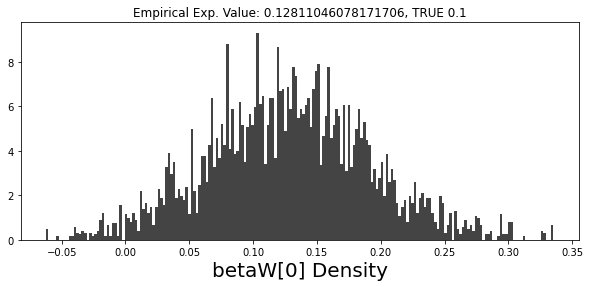

In [59]:
plt.figure(figsize=(10, 4))
plt.hist(betaW0, bins=200, density=True, color='#444444')
plt.xlabel('x', fontsize=20)
plt.xlabel('betaW[0] Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(betaW0)}, TRUE {0.1}')

Text(0.5, 1.0, 'Empirical Exp. Value: -0.5480018877614675, TRUE -0.5')

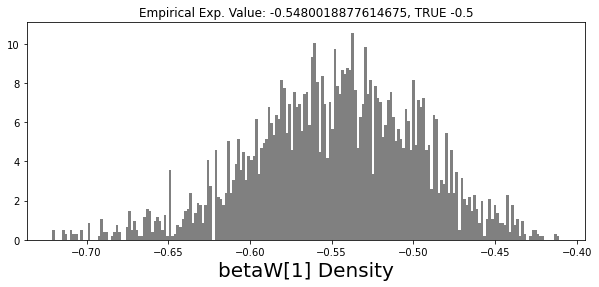

In [60]:
plt.figure(figsize=(10, 4))
plt.hist(betaW1, bins=200, density=True, color='grey')
plt.xlabel('x', fontsize=20)
plt.xlabel('betaW[1] Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(betaW1)}, TRUE {-0.5}')

Text(0.5, 1.0, 'Empirical Exp. Value: 0.5955316187579565, TRUE 0.5')

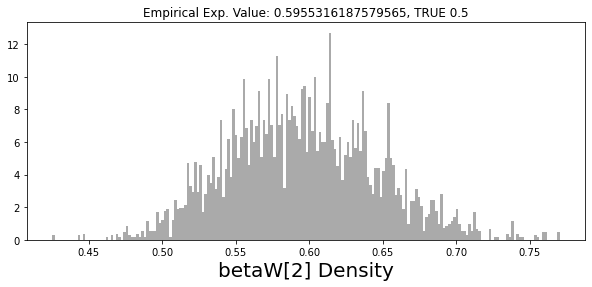

In [61]:
plt.figure(figsize=(10, 4))
plt.hist(betaW2, bins=200, density=True, color='#aaaaaa')
plt.xlabel('x', fontsize=20)
plt.xlabel('betaW[2] Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(betaW2)}, TRUE {0.5}')

## Display $\beta_0$, $\sigma_0^2$, $\beta_1$, $\sigma_1^2$

In [62]:
beta0_hist = np.array(mcmc.betaT_history['beta0'])
beta1_hist = np.array(mcmc.betaT_history['beta1'])
sig0_hist = np.array(mcmc.betaT_history['sigma0'])
sig1_hist = np.array(mcmc.betaT_history['sigma1'])

In [63]:
betaT00 = beta0_hist[500:, 0]
betaT01 = beta0_hist[500:, 1]
betaT02 = beta0_hist[500:, 2]

Text(0.5, 1.0, 'Empirical Exp. Value: 0.8457819059034777, TRUE 1')

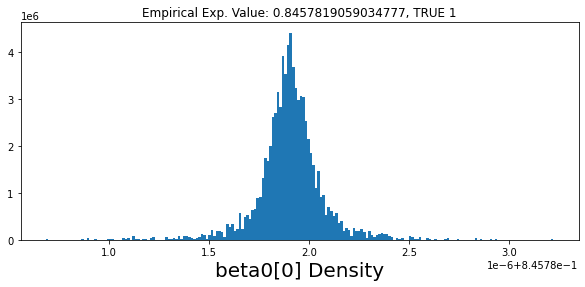

In [64]:
plt.figure(figsize=(10, 4))
plt.hist(betaT00, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('beta0[0] Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(betaT00)}, TRUE {1}')

Text(0.5, 1.0, 'Empirical Exp. Value: -1.8568439922701756, TRUE -2')

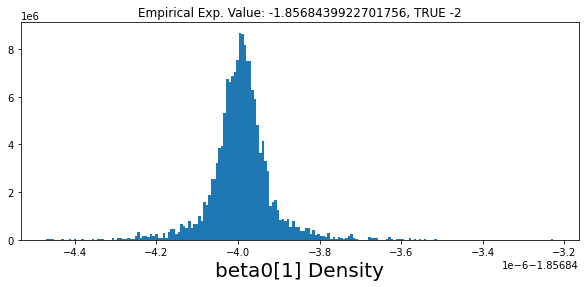

In [65]:
plt.figure(figsize=(10, 4))
plt.hist(betaT01, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('beta0[1] Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(betaT01)}, TRUE {-2}')

Text(0.5, 1.0, 'Empirical Exp. Value: 2.9319797602986983, TRUE 3')

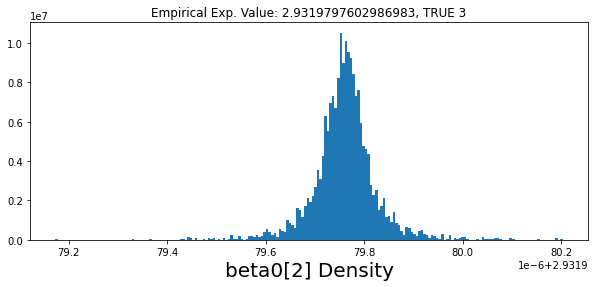

In [66]:
plt.figure(figsize=(10, 4))
plt.hist(betaT02, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('beta0[2] Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(betaT02)}, TRUE {3}')

In [67]:
betaT10 = beta1_hist[500:, 0]
betaT11 = beta1_hist[500:, 1]
betaT12 = beta1_hist[500:, 2]

Text(0.5, 1.0, 'Empirical Exp. Value: 0.4334563652888772, TRUE 0.5')

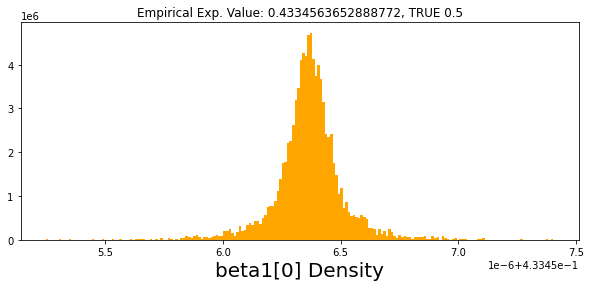

In [68]:
plt.figure(figsize=(10, 4))
plt.hist(betaT10, bins=200, density=True, color='orange')
plt.xlabel('x', fontsize=20)
plt.xlabel('beta1[0] Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(betaT10)}, TRUE {0.5}')

Text(0.5, 1.0, 'Empirical Exp. Value: -0.3307015656147374, TRUE -0.3')

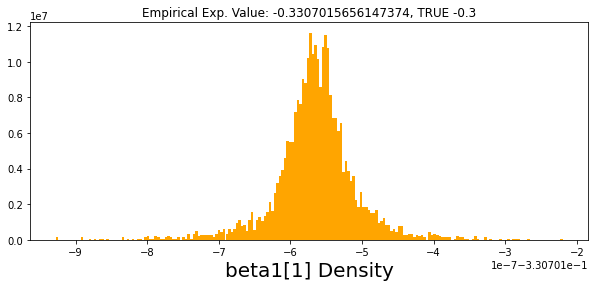

In [69]:
plt.figure(figsize=(10, 4))
plt.hist(betaT11, bins=200, density=True, color='orange')
plt.xlabel('x', fontsize=20)
plt.xlabel('beta1[1] Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(betaT11)}, TRUE {-0.3}')

Text(0.5, 1.0, 'Empirical Exp. Value: 0.14216346298801658, TRUE 0.1')

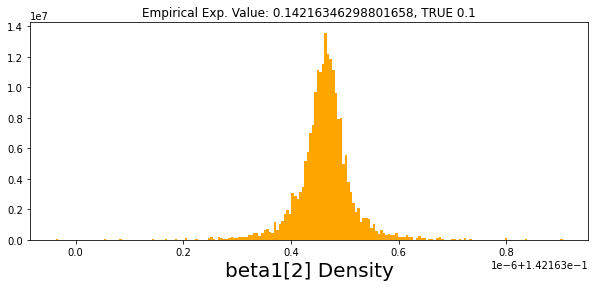

In [70]:
plt.figure(figsize=(10, 4))
plt.hist(betaT12, bins=200, density=True, color='orange')
plt.xlabel('x', fontsize=20)
plt.xlabel('beta1[2] Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(betaT12)}, TRUE {0.1}')

In [71]:
sigT0 = sig0_hist[500:]
sigT1 = sig1_hist[500:]

Text(0.5, 1.0, 'Empirical Exp. Value: 3.290991821009919e-12')

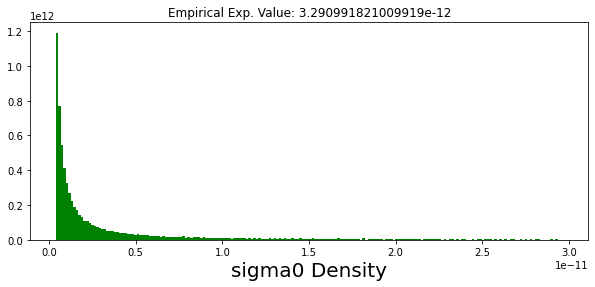

In [72]:
plt.figure(figsize=(10, 4))
plt.hist(sigT0, bins=200, density=True, color='green')
plt.xlabel('x', fontsize=20)
plt.xlabel('sigma0 Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(sigT0)}')

Text(0.5, 1.0, 'Empirical Exp. Value: 3.2874331885937263e-12')

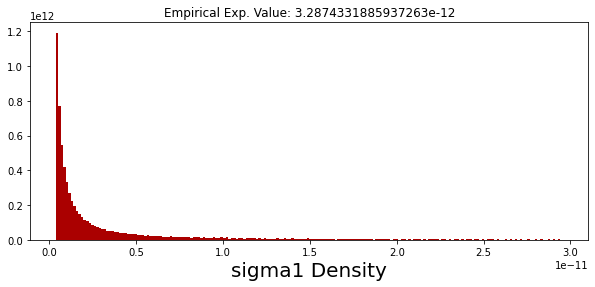

In [73]:
plt.figure(figsize=(10, 4))
plt.hist(sigT1, bins=200, density=True, color='#aa0000')
plt.xlabel('x', fontsize=20)
plt.xlabel('sigma1 Density', fontsize=20)

plt.title(f'Empirical Exp. Value: {np.mean(sigT1)}')